# Library import

In [1]:
!wget https://aistages-api-public-prod.s3.amazonaws.com/app/Competitions/000307/data/data.tar.gz
!tar -xzvf data.tar.gz

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.quarantine'
data/test/1667.JPEG
data/test/._9257.JPEG
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.quarantine'
data/test/9257.JPEG
data/test/._652.JPEG
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.quarantine'
data/test/652.JPEG
data/test/._6458.JPEG
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.quarantine'
data/test/6458.JPEG
data/test/._4465.JPEG
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.quarantine'
data/test/4465.JPEG
data/test/._982.JPEG
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.quarantine'
data/test/982.JPEG
data/test/._73.JPEG
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.quarantine'
data/test/73.JPEG
data/test/._2362.JPEG
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.qu

In [2]:
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 37.3 MB/s eta 0:00:00


In [3]:
# 필요 library들을 import합니다.
import os
from typing import Tuple, Any, Callable, List, Optional, Union

import cv2
import timm
import torch
import numpy as np
import pandas as pd
import albumentations as A
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import models, datasets, transforms
from tqdm.auto import tqdm
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from albumentations.pytorch import ToTensorV2

# Dataset Class

In [4]:
class CustomDataset(Dataset):
    def __init__(
        self,
        root_dir: str,
        info_df: pd.DataFrame,
        transform: Callable,
        is_inference: bool = False
    ):
        # 데이터셋의 기본 경로, 이미지 변환 방법, 이미지 경로 및 레이블을 초기화합니다.
        self.root_dir = root_dir  # 이미지 파일들이 저장된 기본 디렉토리
        self.transform = transform  # 이미지에 적용될 변환 처리
        self.is_inference = is_inference # 추론인지 확인
        self.image_paths = info_df['image_path'].tolist()  # 이미지 파일 경로 목록

        if not self.is_inference:
            self.targets = info_df['target'].tolist()  # 각 이미지에 대한 레이블 목록

    def __len__(self) -> int:
        # 데이터셋의 총 이미지 수를 반환합니다.
        return len(self.image_paths)

    def __getitem__(self, index: int) -> Union[Tuple[torch.Tensor, int], torch.Tensor]:
        # 주어진 인덱스에 해당하는 이미지를 로드하고 변환을 적용한 후, 이미지와 레이블을 반환합니다.
        img_path = os.path.join(self.root_dir, self.image_paths[index])  # 이미지 경로 조합
        image = cv2.imread(img_path, cv2.IMREAD_COLOR)  # 이미지를 BGR 컬러 포맷의 numpy array로 읽어옵니다.
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # BGR 포맷을 RGB 포맷으로 변환합니다.
        image = self.transform(image)  # 설정된 이미지 변환을 적용합니다.

        if self.is_inference:
            return image
        else:
            target = self.targets[index]  # 해당 이미지의 레이블
            return image, target  # 변환된 이미지와 레이블을 튜플 형태로 반환합니다.

# Transform Class

In [5]:
class TorchvisionTransform: # 단순한 전처리, 간편한 사용, 증강이 사용되면 제한적일 수 있음
    def __init__(self, is_train: bool = True):
        # 공통 변환 설정: 이미지 리사이즈, 텐서 변환, 정규화
        common_transforms = [
            transforms.Resize((224, 224)),  # 이미지를 224x224 크기로 리사이즈
            transforms.ToTensor(),  # 이미지를 PyTorch 텐서로 변환
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # 정규화
        ]

        if is_train:
            # 훈련용 변환: 랜덤 수평 뒤집기, 랜덤 회전, 색상 조정 추가
            self.transform = transforms.Compose(
                [
                    transforms.RandomHorizontalFlip(p=0.5),  # 50% 확률로 이미지를 수평 뒤집기
                    transforms.RandomRotation(15),  # 최대 15도 회전
                    transforms.ColorJitter(brightness=0.2, contrast=0.2),  # 밝기 및 대비 조정
                ] + common_transforms
            )
        else:
            # 검증/테스트용 변환: 공통 변환만 적용
            self.transform = transforms.Compose(common_transforms)

    def __call__(self, image: np.ndarray) -> torch.Tensor:
        image = Image.fromarray(image)  # numpy 배열을 PIL 이미지로 변환

        transformed = self.transform(image)  # 설정된 변환을 적용

        return transformed  # 변환된 이미지 반환

In [8]:
class AlbumentationsTransform: # 대규모, 복잡한 데이터 증강 때 사용
    def __init__(self, is_train: bool = True):
        # 공통 변환 설정: 이미지 리사이즈, 정규화, 텐서 변환
        common_transforms = [
            A.Resize(224, 224),  # 이미지를 224x224 크기로 리사이즈
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # 정규화
            ToTensorV2()  # albumentations에서 제공하는 PyTorch 텐서 변환
        ]

        if is_train:
            # 훈련용 변환: 랜덤 수평 뒤집기, 랜덤 회전, 랜덤 밝기 및 대비 조정 추가
            self.transform = A.Compose(
                [
                    A.VerticalFlip(p=0.5),  # 50% 확률로 이미지를 수평 뒤집기
                    A.Rotate(limit=15),  # 최대 15도 회전
                    A.RandomBrightnessContrast(p=0.2),  # 밝기 및 대비 무작위 조정
                ] + common_transforms
            )
        else:
            # 검증/테스트용 변환: 공통 변환만 적용
            self.transform = A.Compose(common_transforms)

    def __call__(self, image) -> torch.Tensor:
        # 이미지가 NumPy 배열인지 확인
        if not isinstance(image, np.ndarray):
            raise TypeError("Image should be a NumPy array (OpenCV format).")

        # 이미지에 변환 적용 및 결과 반환
        transformed = self.transform(image=image)  # 이미지에 설정된 변환을 적용

        return transformed['image']  # 변환된 이미지의 텐서를 반환

In [7]:
class TransformSelector:
    """
    이미지 변환 라이브러리를 선택하기 위한 클래스.
    """
    def __init__(self, transform_type: str):

        # 지원하는 변환 라이브러리인지 확인
        if transform_type in ["torchvision", "albumentations"]:
            self.transform_type = transform_type

        else:
            raise ValueError("Unknown transformation library specified.")

    def get_transform(self, is_train: bool):

        # 선택된 라이브러리에 따라 적절한 변환 객체를 생성
        if self.transform_type == 'torchvision':
            transform = TorchvisionTransform(is_train=is_train)

        elif self.transform_type == 'albumentations':
            transform = AlbumentationsTransform(is_train=is_train)

        return transform

# Model Class

In [9]:
class SimpleCNN(nn.Module):
    """
    간단한 CNN 아키텍처를 정의하는 클래스.
    """
    def __init__(self, num_classes: int):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:

        # 순전파 함수 정의
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = torch.flatten(x, 1)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)

        return x

In [10]:
class TorchvisionModel(nn.Module):
    """
    Torchvision에서 제공하는 사전 훈련된 모델을 사용하는 클래스.
    """
    def __init__(
        self,
        model_name: str,
        num_classes: int,
        pretrained: bool
    ):
        super(TorchvisionModel, self).__init__()
        self.model = models.__dict__[model_name](pretrained=pretrained)

        # 모델의 최종 분류기 부분을 사용자 정의 클래스 수에 맞게 조정
        if 'fc' in dir(self.model):
            num_ftrs = self.model.fc.in_features
            self.model.fc = nn.Linear(num_ftrs, num_classes)

        elif 'classifier' in dir(self.model):
            num_ftrs = self.model.classifier[-1].in_features
            self.model.classifier[-1] = nn.Linear(num_ftrs, num_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:

        return self.model(x)

In [11]:
class TimmModel(nn.Module):
    """
    Timm 라이브러리를 사용하여 다양한 사전 훈련된 모델을 제공하는 클래스.
    """
    def __init__(
        self,
        model_name: str,
        num_classes: int,
        pretrained: bool
    ):
        super(TimmModel, self).__init__()
        self.model = timm.create_model(
            model_name,
            pretrained=pretrained,
            num_classes=num_classes
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:

        return self.model(x)

In [31]:
# import torch.nn as nn

# class TimmModel(nn.Module):
#     """
#     Timm 라이브러리의 사전 훈련된 ResNet50V2 모델을 기반으로 추가 FC 레이어를 더한 모델.
#     """
#     def __init__(self, model_name: str, num_classes: int, pretrained: bool = True):
#         super(TimmModel, self).__init__()
#         # Timm 라이브러리로 ResNet50V2 모델 불러오기 (사전 훈련된 모델)
#         self.model = timm.create_model(
#             model_name,  # 예: 'resnet50', 'resnet50v2' 등 사용 가능
#             pretrained=pretrained,
#             num_classes=0  # num_classes=0으로 설정해서 기존 FC 레이어를 제거
#         )

#         # 추가 레이어 (Flatten, Dense(256), Dense(num_classes))
#         self.flatten = nn.Flatten()
#         self.fc1 = nn.Linear(self.model.num_features, 256)  # ResNet의 마지막 출력 feature 수를 입력으로
#         self.relu = nn.ReLU()
#         self.fc2 = nn.Linear(256, num_classes)  # 최종 분류를 위한 FC 레이어
#         self.softmax = nn.Softmax(dim=1)  # 다중 클래스 분류를 위한 Softmax

#     def forward(self, x: torch.Tensor) -> torch.Tensor:
#         # ResNet50V2 모델의 기본 feature extractor 부분
#         x = self.model(x)

#         # Flatten -> Dense(256) -> ReLU -> Dense(num_classes) -> Softmax
#         x = self.flatten(x)
#         x = self.fc1(x)
#         x = self.relu(x)
#         x = self.fc2(x)
#         x = self.softmax(x)

#         return x

Fine-tuning

In [12]:
def fine_tune_model(model: nn.Module, freeze_until_layer: str, train_loader: DataLoader,
                    val_loader: DataLoader, num_epochs: int, learning_rate: float = 1e-4, device: str = 'cuda'):
    """
    A function for fine tuning by freezing a specific layer in a pre-trained model.

    Parameters:
    - model: Pre-trained model (ResNet50V2, etc.)
    - freeze_until_layer: specific layer name. Freeze all layers before this layer.
    - train_loader: DataLoader for training data
    - val_loader: DataLoader for validation data
    - num_epochs: Number of epochs to train
    - learning_rate: Learning rate for optimization
    - device: 'cuda' or 'cpu'

    Returns:
    - model: fine tuned model
    """
    # Move model to device (CPU or GPU)
    model.to(device)

    # Freeze all layers before the specified layer
    for param in model.parameters():
        param.requires_grad = False

    # Set layers after the specified one to be trainable
    freeze = True
    for name, param in model.named_parameters():
        if freeze and freeze_until_layer in name:
            freeze = False
        if not freeze:
            param.requires_grad = True

    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate)

   # Initialize variables for model saving
    best_models = []
    lowest_loss = float('inf')

    result_path = "/content/fine_tuning"

    # Training loop
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        running_loss = 0.0
        correct = 0
        total = 0

        # Training step
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            # Statistics
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        # Calculate epoch loss and accuracy
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100 * correct / total
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%')

        # Validation step
        model.eval()  # Set model to evaluation mode
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_loss /= len(val_loader)
        val_acc = 100 * val_correct / val_total
        print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.2f}%')

        # Save the current epoch model
        current_model_path = os.path.join(result_path, f'model_epoch_{epoch}_loss_{val_loss:.4f}.pt')
        torch.save(model.state_dict(), current_model_path)

        # Track the best models
        best_models.append((val_loss, epoch, current_model_path))
        best_models.sort()  # Sort by loss (ascending)
        if len(best_models) > 3:
            _, _, path_to_remove = best_models.pop(-1)  # Remove the model with the highest loss
            if os.path.exists(path_to_remove):
                os.remove(path_to_remove)

        # Save the best model
        if val_loss < lowest_loss:
            lowest_loss = val_loss
            best_model_path = os.path.join(result_path, 'fine_best_model.pt')
            torch.save(model.state_dict(), best_model_path)
            print(f"Best model updated: Epoch {epoch}, Loss = {val_loss:.4f}")

    return model

In [13]:
class ModelSelector:
    """
    사용할 모델 유형을 선택하는 클래스.
    """
    def __init__(
        self,
        model_type: str,
        num_classes: int,
        **kwargs
    ):

        # 모델 유형에 따라 적절한 모델 객체를 생성
        if model_type == 'simple':
            self.model = SimpleCNN(num_classes=num_classes)

        elif model_type == 'torchvision':
            self.model = TorchvisionModel(num_classes=num_classes, **kwargs)

        elif model_type == 'timm':
            self.model = TimmModel(num_classes=num_classes, **kwargs)

        else:
            raise ValueError("Unknown model type specified.")

    def get_model_name(self): return self.model_name

    def get_model(self) -> nn.Module:

        # 생성된 모델 객체 반환
        return self.model

data 시각화

In [14]:
import random
import cv2
import matplotlib.pyplot as plt

def visualize_random_images_from_csv(csv_file, image_dir, num_samples=5, figsize=(20, 20)):
    """
    CSV 파일에서 이미지 경로를 무작위로 선택해 시각화하는 함수.

    Parameters:
    - csv_file: 이미지 경로와 라벨이 있는 CSV 파일 경로
    - image_dir: 실제 이미지 파일이 있는 디렉토리 경로
    - num_samples: 시각화할 이미지 개수 (기본값 5)
    - figsize: 출력 이미지 크기 (기본값 (20, 20))
    """

    # CSV 파일 읽기
    df = pd.read_csv(csv_file)

    # image_path 열에서 무작위로 num_samples 개 선택
    random_samples = df.sample(n=num_samples)

    plt.figure(figsize=figsize)

    for i, row in enumerate(random_samples.itertuples()):
        # 이미지 경로 가져오기
        img_path = f"{image_dir}/{row.image_path}"

        # OpenCV로 이미지 읽기 (BGR로 읽으므로 RGB로 변환)
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        plt.subplot(int(np.sqrt(num_samples)), int(np.sqrt(num_samples)), i + 1)
        plt.imshow(image)

        # 라벨이 있다면 클래스 이름을 타이틀로 표시
        if 'target' in df.columns:
            class_name = str(row.target)  # 라벨은 'target' 열에 있다고 가정
            plt.title(f"Class: {class_name}", color='blue', fontsize=12)
        else:
            plt.title(f"Image {i+1}", color='blue', fontsize=12)

        plt.axis('off')

    plt.show()

# Loss Class

In [15]:
class Loss(nn.Module):
    """
    모델의 손실함수를 계산하는 클래스.
    """
    def __init__(self):
        super(Loss, self).__init__()
        self.loss_fn = nn.CrossEntropyLoss()

    def forward(
        self,
        outputs: torch.Tensor,
        targets: torch.Tensor
    ) -> torch.Tensor:

        return self.loss_fn(outputs, targets)

# Trainer Class

In [16]:
class Trainer:
    def __init__(
        self,
        model: nn.Module,
        device: torch.device,
        train_loader: DataLoader,
        val_loader: DataLoader,
        optimizer: optim.Optimizer,
        scheduler: optim.lr_scheduler,
        loss_fn: torch.nn.modules.loss._Loss,
        epochs: int,
        result_path: str
    ):
        # 클래스 초기화: 모델, 디바이스, 데이터 로더 등 설정
        self.model = model  # 훈련할 모델
        self.device = device  # 연산을 수행할 디바이스 (CPU or GPU)
        self.train_loader = train_loader  # 훈련 데이터 로더
        self.val_loader = val_loader  # 검증 데이터 로더
        self.optimizer = optimizer  # 최적화 알고리즘
        self.scheduler = scheduler # 학습률 스케줄러
        self.loss_fn = loss_fn  # 손실 함수
        self.epochs = epochs  # 총 훈련 에폭 수
        self.result_path = result_path  # 모델 저장 경로
        self.best_models = [] # 가장 좋은 상위 3개 모델의 정보를 저장할 리스트
        self.lowest_loss = float('inf') # 가장 낮은 Loss를 저장할 변수

    def save_model(self, epoch, loss):
        # 모델 저장 경로 설정
        os.makedirs(self.result_path, exist_ok=True)

        # 현재 에폭 모델 저장
        current_model_path = os.path.join(self.result_path, f'model_epoch_{epoch}_loss_{loss:.4f}.pt')
        torch.save(self.model.state_dict(), current_model_path)

        # 최상위 3개 모델 관리
        self.best_models.append((loss, epoch, current_model_path))
        self.best_models.sort()
        if len(self.best_models) > 3:
            _, _, path_to_remove = self.best_models.pop(-1)  # 가장 높은 손실 모델 삭제
            if os.path.exists(path_to_remove):
                os.remove(path_to_remove)

        # 가장 낮은 손실의 모델 저장
        if loss < self.lowest_loss:
            self.lowest_loss = loss
            best_model_path = os.path.join(self.result_path, 'best_model.pt')
            torch.save(self.model.state_dict(), best_model_path)
            print(f"Save {epoch}epoch result. Loss = {loss:.4f}")

    def train_epoch(self) -> float:
        # 한 에폭 동안의 훈련을 진행
        self.model.train()

        total_loss = 0.0
        progress_bar = tqdm(self.train_loader, desc="Training", leave=False)

        for images, targets in progress_bar:
            images, targets = images.to(self.device), targets.to(self.device)
            self.optimizer.zero_grad()
            outputs = self.model(images)
            loss = self.loss_fn(outputs, targets)
            loss.backward()
            self.optimizer.step()
            self.scheduler.step()
            total_loss += loss.item()
            progress_bar.set_postfix(loss=loss.item())

        return total_loss / len(self.train_loader)

    def validate(self) -> float:
        # 모델의 검증을 진행
        self.model.eval()

        total_loss = 0.0
        progress_bar = tqdm(self.val_loader, desc="Validating", leave=False)

        with torch.no_grad():
            for images, targets in progress_bar:
                images, targets = images.to(self.device), targets.to(self.device)
                outputs = self.model(images)
                loss = self.loss_fn(outputs, targets)
                total_loss += loss.item()
                progress_bar.set_postfix(loss=loss.item())

        return total_loss / len(self.val_loader)

    def train(self) -> None:
        # 전체 훈련 과정을 관리
        for epoch in range(self.epochs):
            print(f"Epoch {epoch+1}/{self.epochs}")

            train_loss = self.train_epoch()
            val_loss = self.validate()
            print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}\n")

            self.save_model(epoch, val_loss)
            self.scheduler.step()

# Model Training

In [17]:
# 학습에 사용할 장비를 선택.
# torch라이브러리에서 gpu를 인식할 경우, cuda로 설정.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [18]:
# 학습 데이터의 경로와 정보를 가진 파일의 경로를 설정.
traindata_dir = "./data/train"
traindata_info_file = "./data/train.csv"
save_result_path = "./train_result"

In [19]:
# 학습 데이터의 class, image path, target에 대한 정보가 들어있는 csv파일을 읽기.
train_info = pd.read_csv(traindata_info_file)

# 총 class의 수를 측정.
num_classes = len(train_info['target'].unique())

# 각 class별로 8:2의 비율이 되도록 학습과 검증 데이터를 분리.
train_df, val_df = train_test_split(
    train_info,
    test_size=0.2,
    stratify=train_info['target']
)

In [20]:
# 학습에 사용할 Transform을 선언.
transform_selector = TransformSelector(
    transform_type = "albumentations"
)
train_transform = transform_selector.get_transform(is_train=True)
val_transform = transform_selector.get_transform(is_train=False)

# 학습에 사용할 Dataset을 선언.
train_dataset = CustomDataset(
    root_dir=traindata_dir,
    info_df=train_df,
    transform=train_transform
)
val_dataset = CustomDataset(
    root_dir=traindata_dir,
    info_df=val_df,
    transform=val_transform
)

# 학습에 사용할 DataLoader를 선언.
train_loader = DataLoader(
    train_dataset,
    batch_size=64,
    shuffle=True
)
val_loader = DataLoader(
    val_dataset,
    batch_size=64,
    shuffle=False
)

In [21]:
# 학습에 사용할 Model을 선언.
model_selector = ModelSelector(
    model_type='timm',
    num_classes=num_classes,
    model_name='resnet50',
    pretrained=True
)
model = model_selector.get_model()

# 선언된 모델을 학습에 사용할 장비로 셋팅.
model.to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

TimmModel(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act1): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (drop_block): Identity()
        (act2): ReLU(inplace=True)
        (aa): Identity()
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, mome

In [22]:
# 학습에 사용할 optimizer를 선언하고, learning rate를 지정
optimizer = optim.Adam(
    model.parameters(),
    lr=0.001
)

In [23]:
# 스케줄러 초기화
scheduler_step_size = 30  # 매 30step마다 학습률 감소
scheduler_gamma = 0.1  # 학습률을 현재의 10%로 감소

# 한 epoch당 step 수 계산
steps_per_epoch = len(train_loader)

# 2 epoch마다 학습률을 감소시키는 스케줄러 선언
epochs_per_lr_decay = 2
scheduler_step_size = steps_per_epoch * epochs_per_lr_decay

scheduler = optim.lr_scheduler.StepLR(
    optimizer,
    step_size=scheduler_step_size,
    gamma=scheduler_gamma
)

In [24]:
# 학습에 사용할 Loss를 선언.
loss_fn = Loss()

In [25]:
# 앞서 선언한 필요 class와 변수들을 조합해, 학습을 진행할 Trainer를 선언.
trainer = Trainer(
    model=model,
    device=device,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    scheduler=scheduler,
    loss_fn=loss_fn,
    epochs=15,
    result_path=save_result_path
)

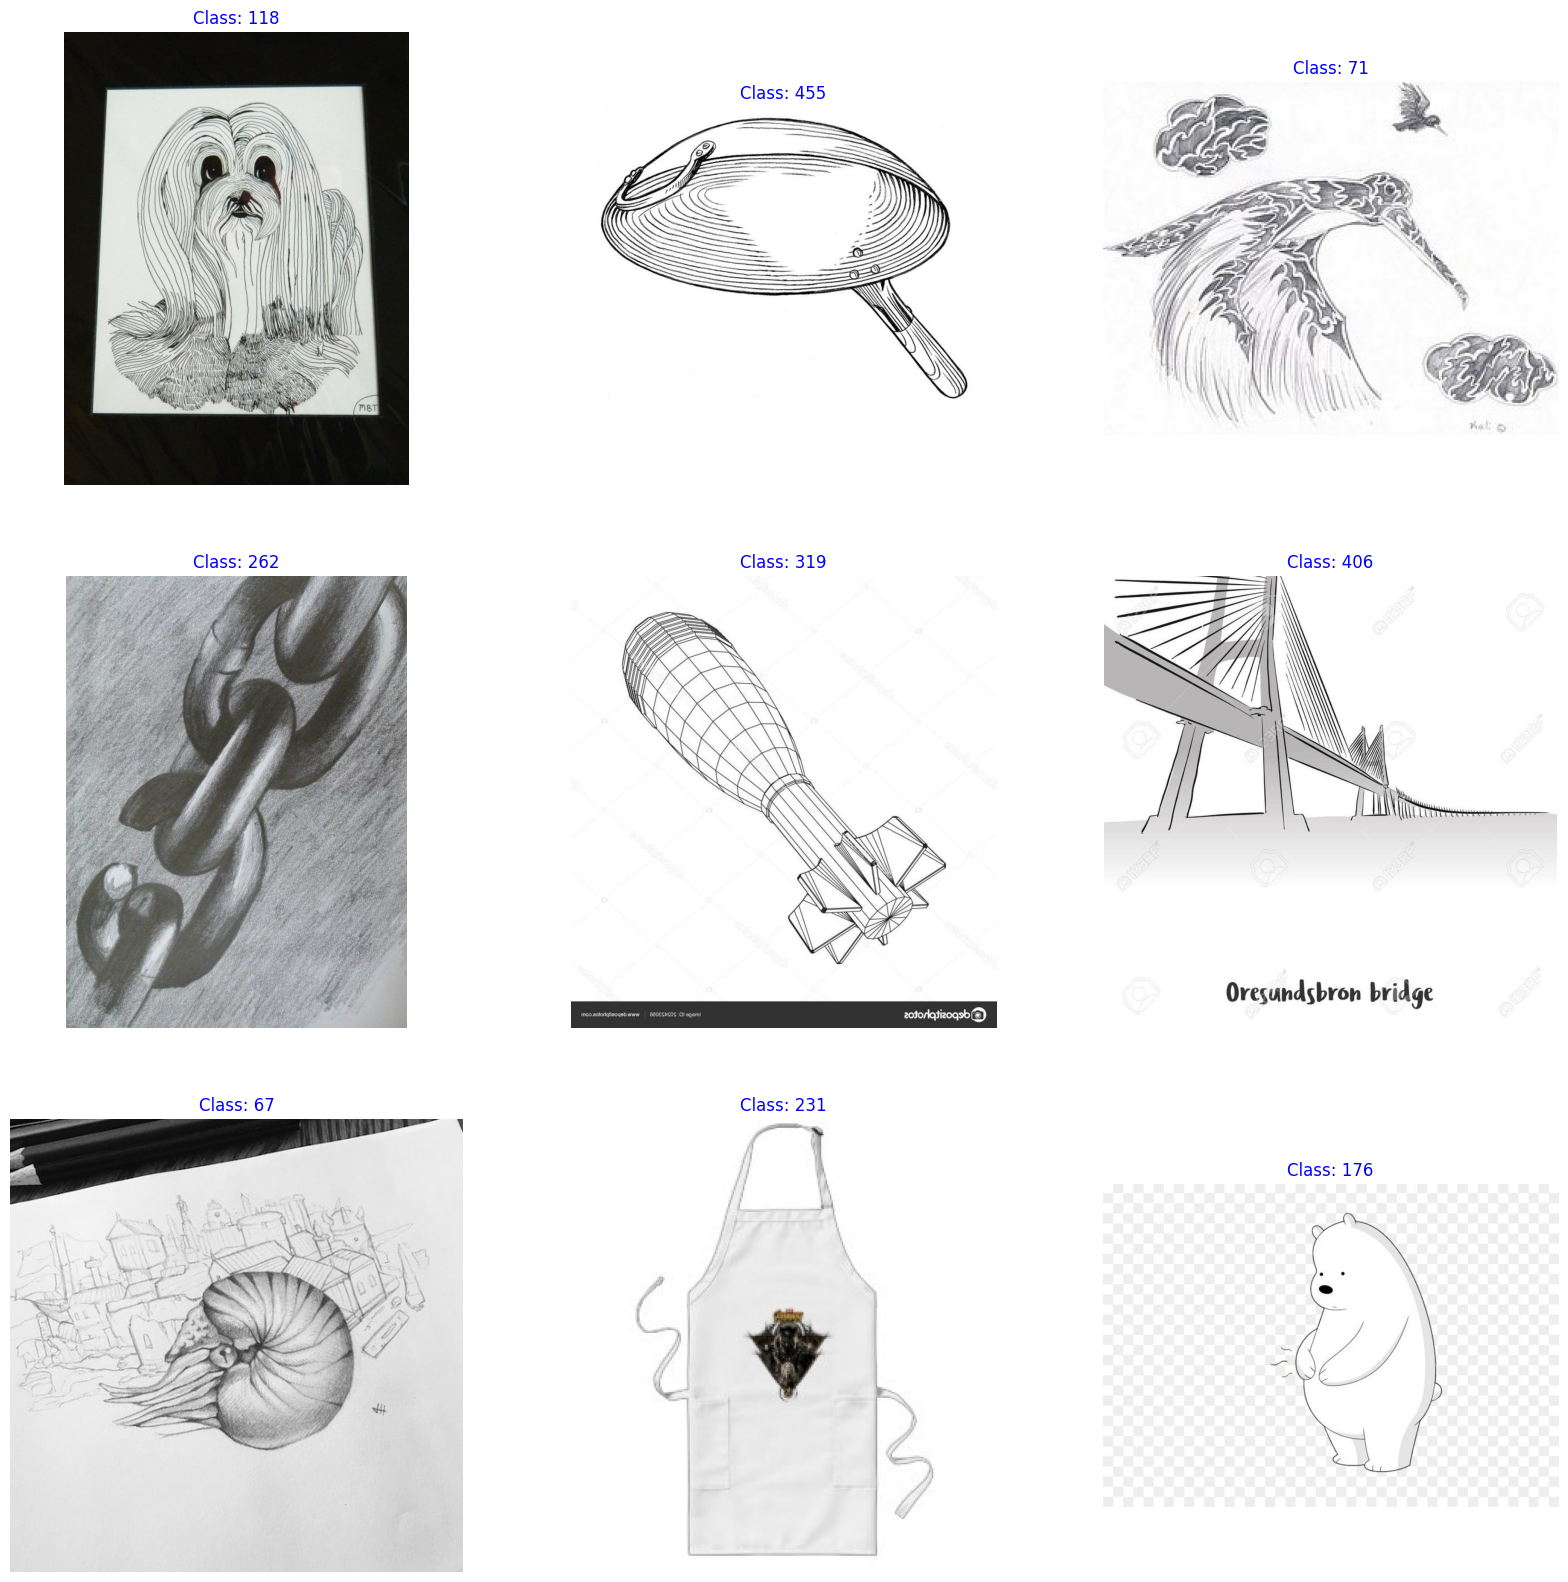

In [33]:
# 이미지 시각화
visualize_random_images_from_csv(traindata_info_file, traindata_dir, 9, figsize=(20,20))

In [34]:
# 모델 학습.
trainer.train()

Epoch 1/15


Training:   0%|          | 0/188 [00:00<?, ?it/s]

Validating:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 1, Train Loss: 4.3872, Validation Loss: 2.2144

Save 0epoch result. Loss = 2.2144
Epoch 2/15


Training:   0%|          | 0/188 [00:00<?, ?it/s]

Validating:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 2, Train Loss: 1.5103, Validation Loss: 1.8318

Save 1epoch result. Loss = 1.8318
Epoch 3/15


Training:   0%|          | 0/188 [00:00<?, ?it/s]

Validating:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 3, Train Loss: 0.6678, Validation Loss: 1.4685

Save 2epoch result. Loss = 1.4685
Epoch 4/15


Training:   0%|          | 0/188 [00:00<?, ?it/s]

Validating:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 4, Train Loss: 0.4906, Validation Loss: 1.3245

Save 3epoch result. Loss = 1.3245
Epoch 5/15


Training:   0%|          | 0/188 [00:00<?, ?it/s]

Validating:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 5, Train Loss: 0.4138, Validation Loss: 1.5285

Epoch 6/15


Training:   0%|          | 0/188 [00:00<?, ?it/s]

Validating:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 6, Train Loss: 0.4138, Validation Loss: 1.2362

Save 5epoch result. Loss = 1.2362
Epoch 7/15


Training:   0%|          | 0/188 [00:00<?, ?it/s]

Validating:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 7, Train Loss: 0.3964, Validation Loss: 1.5094

Epoch 8/15


Training:   0%|          | 0/188 [00:00<?, ?it/s]

Validating:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 8, Train Loss: 0.3989, Validation Loss: 1.4551

Epoch 9/15


Training:   0%|          | 0/188 [00:00<?, ?it/s]

Validating:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 9, Train Loss: 0.3959, Validation Loss: 1.4720

Epoch 10/15


Training:   0%|          | 0/188 [00:00<?, ?it/s]

Validating:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 10, Train Loss: 0.3975, Validation Loss: 1.4412

Epoch 11/15


Training:   0%|          | 0/188 [00:00<?, ?it/s]

Validating:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 11, Train Loss: 0.3996, Validation Loss: 1.4166

Epoch 12/15


Training:   0%|          | 0/188 [00:00<?, ?it/s]

Validating:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 12, Train Loss: 0.4063, Validation Loss: 1.3548

Epoch 13/15


Training:   0%|          | 0/188 [00:00<?, ?it/s]

Validating:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 13, Train Loss: 0.3967, Validation Loss: 1.4430

Epoch 14/15


Training:   0%|          | 0/188 [00:00<?, ?it/s]

Validating:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 14, Train Loss: 0.4013, Validation Loss: 1.3014

Epoch 15/15


Training:   0%|          | 0/188 [00:00<?, ?it/s]

Validating:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 15, Train Loss: 0.4012, Validation Loss: 1.3072



In [35]:
print(model_selector.get_model_name())

AttributeError: 'ModelSelector' object has no attribute 'model_name'

In [49]:
if model_selector.get_model_name() == "resnet50d":
  # 파인튜닝 함수 호출
  fine_tuned_model = fine_tune_model(
      model=model,                  # 사전 훈련된 모델
      freeze_until_layer='layer4',   # 'layer4' 이전 레이어는 동결
      train_loader=train_loader,     # 학습 데이터 로더
      val_loader=val_loader,         # 검증 데이터 로더
      num_epochs=15,                 # 에포크 수
      learning_rate=1e-4,            # 학습률
      device='cuda'                  # 학습할 디바이스 (GPU)
  )

AttributeError: 'TimmModel' object has no attribute 'model_name'

In [38]:
  fine_tuned_model = fine_tune_model(
      model=model,                  # 사전 훈련된 모델
      freeze_until_layer='layer4',   # 'layer4' 이전 레이어는 동결
      train_loader=train_loader,     # 학습 데이터 로더
      val_loader=val_loader,         # 검증 데이터 로더
      num_epochs=10,                 # 에포크 수
      learning_rate=1e-4,            # 학습률
      device='cuda'                  # 학습할 디바이스 (GPU)
  )

Epoch [1/10], Loss: 0.3583, Accuracy: 91.28%
Validation Loss: 1.3793, Validation Accuracy: 76.54%
Best model updated: Epoch 0, Loss = 1.3793
Epoch [2/10], Loss: 0.3119, Accuracy: 92.72%
Validation Loss: 1.4000, Validation Accuracy: 77.14%
Epoch [3/10], Loss: 0.2825, Accuracy: 93.26%
Validation Loss: 1.2694, Validation Accuracy: 77.60%
Best model updated: Epoch 2, Loss = 1.2694
Epoch [4/10], Loss: 0.2488, Accuracy: 94.24%
Validation Loss: 1.2898, Validation Accuracy: 77.64%
Epoch [5/10], Loss: 0.2245, Accuracy: 95.01%
Validation Loss: 1.3726, Validation Accuracy: 77.90%
Epoch [6/10], Loss: 0.2028, Accuracy: 95.42%
Validation Loss: 1.3252, Validation Accuracy: 78.50%
Epoch [7/10], Loss: 0.1856, Accuracy: 95.76%
Validation Loss: 1.3820, Validation Accuracy: 78.74%
Epoch [8/10], Loss: 0.1728, Accuracy: 96.35%
Validation Loss: 1.4660, Validation Accuracy: 79.17%
Epoch [9/10], Loss: 0.1579, Accuracy: 96.56%
Validation Loss: 1.3172, Validation Accuracy: 79.17%
Epoch [10/10], Loss: 0.1442, Acc

# Inference

In [39]:
# 모델 추론을 위한 함수
def inference(
    model: nn.Module,
    device: torch.device,
    test_loader: DataLoader
):
    # 모델을 평가 모드로 설정
    model.to(device)
    model.eval()

    predictions = []
    with torch.no_grad():  # Gradient 계산을 비활성화
        for images in tqdm(test_loader):
            # 데이터를 같은 장치로 이동
            images = images.to(device)

            # 모델을 통해 예측 수행
            logits = model(images)
            logits = F.softmax(logits, dim=1)
            preds = logits.argmax(dim=1)

            # 예측 결과 저장
            predictions.extend(preds.cpu().detach().numpy())  # 결과를 CPU로 옮기고 리스트에 추가

    return predictions

In [40]:
# 추론 데이터의 경로와 정보를 가진 파일의 경로를 설정.
testdata_dir = "./data/test"
testdata_info_file = "./data/test.csv"
save_result_path = "./train_result"

In [41]:
# 추론 데이터의 class, image path, target에 대한 정보가 들어있는 csv파일을 읽기.
test_info = pd.read_csv(testdata_info_file)

# 총 class 수.
num_classes = 500

In [42]:
# 추론에 사용할 Transform을 선언.
transform_selector = TransformSelector(
    transform_type = "albumentations"
)
test_transform = transform_selector.get_transform(is_train=False)

# 추론에 사용할 Dataset을 선언.
test_dataset = CustomDataset(
    root_dir=testdata_dir,
    info_df=test_info,
    transform=test_transform,
    is_inference=True
)

# 추론에 사용할 DataLoader를 선언.
test_loader = DataLoader(
    test_dataset,
    batch_size=64,
    shuffle=False,
    drop_last=False
)

In [44]:
# 추론에 사용할 장비를 선택.
# torch라이브러리에서 gpu를 인식할 경우, cuda로 설정.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 추론에 사용할 Model을 선언.
model_selector = ModelSelector(
    model_type='timm',
    num_classes=num_classes,
    model_name='resnet50',
    pretrained=True
)
model = model_selector.get_model()


In [48]:
# best epoch 모델을 불러오기.
model.load_state_dict(
    torch.load(
        os.path.join(save_result_path, "best_model.pt"),
        map_location='cpu'
    )
)

<ipython-input-48-49a043b75e59>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(


<All keys matched successfully>

In [49]:
# predictions를 CSV에 저장할 때 형식을 맞춰서 저장
# 테스트 함수 호출
predictions = inference(
    model=model,
    device=device,
    test_loader=test_loader
)

  0%|          | 0/157 [00:00<?, ?it/s]

In [50]:
# 모든 클래스에 대한 예측 결과를 하나의 문자열로 합침
test_info['target'] = predictions
test_info = test_info.reset_index().rename(columns={"index": "ID"})
test_info

,ID,ID,image_path,target
0,0,0,0.JPEG,328
1,1,1,1.JPEG,414
2,2,2,2.JPEG,409
3,3,3,3.JPEG,17
4,4,4,4.JPEG,388
...,...,...,...,...
10009,10009,10009,10009.JPEG,235
10010,10010,10010,10010.JPEG,191
10011,10011,10011,10011.JPEG,303
10012,10012,10012,10012.JPEG,322


In [51]:
# DataFrame 저장
test_info.to_csv("./result_2.csv", index=False)

파인튜닝 데이터

In [52]:
# best epoch 모델을 불러오기.
model.load_state_dict(
    torch.load(
        os.path.join('/content/fine_tuning', "fine_best_model.pt"),
        map_location='cpu'
    )
)

<ipython-input-52-caa9265f9667>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(


<All keys matched successfully>

In [53]:
# predictions를 CSV에 저장할 때 형식을 맞춰서 저장
# 테스트 함수 호출
predictions = inference(
    model=model,
    device=device,
    test_loader=test_loader
)

  0%|          | 0/157 [00:00<?, ?it/s]

In [54]:
# 모든 클래스에 대한 예측 결과를 하나의 문자열로 합침
test_info['target'] = predictions
test_info = test_info.reset_index().rename(columns={"index": "ID"})
test_info

,ID,ID,ID,image_path,target
0,0,0,0,0.JPEG,328
1,1,1,1,1.JPEG,414
2,2,2,2,2.JPEG,409
3,3,3,3,3.JPEG,17
4,4,4,4,4.JPEG,388
...,...,...,...,...,...
10009,10009,10009,10009,10009.JPEG,235
10010,10010,10010,10010,10010.JPEG,86
10011,10011,10011,10011,10011.JPEG,303
10012,10012,10012,10012,10012.JPEG,322


In [55]:
# DataFrame 저장
test_info.to_csv("./result_fine_3.csv", index=False)

In [87]:
import pandas as pd

def compare_target_values_and_counts(file1, file2):
    """
    Compare the 'target' column between two CSV files based on the 'ID' column.
    Display the 'ID' values where the 'target' values are exactly the same.
    Also, display the 'ID' values where the 'target' values are different but have the same count.

    Parameters:
    - file1: Path to the first CSV file
    - file2: Path to the second CSV file
    """
    # Read the CSV files into dataframes
    df1 = pd.read_csv(file1)
    df2 = pd.read_csv(file2)

    # Merge the two dataframes on the 'ID' column
    merged_df = pd.merge(df1, df2, on='ID', suffixes=('_file1', '_file2'))

    # 1. Find rows where the 'target' values are the same
    same_values_df = merged_df[merged_df['target_file1'] != merged_df['target_file2']]

    if not same_values_df.empty:
        print("IDs with the same 'target' values:")
        print(same_values_df['ID'].tolist())
    else:
        print("No IDs with the same 'target' values found.")

    # 2. Find rows where 'target' values are different but their counts (frequencies) match
    df1_count = df1['target'].value_counts()
    df2_count = df2['target'].value_counts()

    same_count_targets = df1_count[df1_count.isin(df2_count)].index.tolist()

    if same_count_targets:
        print("\nIDs with different 'target' values but the same frequency (count):")
        for target in same_count_targets:
            # Find IDs with this target in both files
            ids_file1 = df1[df1['target'] == target]['ID'].tolist()
            ids_file2 = df2[df2['target'] == target]['ID'].tolist()

            print(f"Target {target}: File1 IDs = {ids_file1}, File2 IDs = {ids_file2}")
    else:
        print("No 'target' values with the same count but different values found.")

# Example usage
file1 = "/content/result_fine.csv"
file2 = "/content/result.csv"
compare_target_values_and_counts(file1, file2)


IDs with the same 'target' values:
[0, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 16, 17, 18, 19, 21, 23, 24, 25, 27, 28, 29, 30, 32, 33, 34, 35, 38, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 58, 59, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 77, 78, 79, 80, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 94, 95, 97, 98, 99, 102, 103, 104, 105, 106, 109, 110, 111, 112, 115, 116, 118, 119, 120, 121, 123, 124, 125, 127, 128, 129, 131, 132, 134, 135, 137, 138, 139, 141, 142, 144, 145, 146, 147, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 184, 185, 186, 187, 188, 191, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 234, 235, 236, 237, 238, 239, 240, 241, 244, 245, 246, 248, 250, 251, 252, 253, 254, 255, 25